# Single Glomerular Stimulation Detection Training - All Mice Combined

*_This code contains may artifacts from prior iterations and therefore isn't the most efficient._

This code produces a plot which shows all training sessions for all of the mice combined. Specifically, the plot produced shows the mouse's detection rate accross multiple sessions until the mouse learns the task.

### Note on the input data files

The input to this code is a list of H5 files which were output after every session was performed. The nomenclature of these H5 files follows the following example format:

mouse0070_sess01_3750V_D231016.h5

Here, 0070 is the mouse number, 01 is the session number, 3750V indicates that 3.75V were applied to the AOM which modulates the stimulation laser's power, and the date of the session follows. 

In [1]:
import os
import h5py
import re
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

### Create a sting of mouse labels which will help us reference the necessary H5 files.
The names of the behavioral H5 files contain the labels of the mice which underwent training ie. mouseXXXX.

In [2]:
string_patterns = ["*mouse0691*.h5", "*mouse0070*.h5", "*mouse0071*.h5", "*mouse0721*.h5", "*mouse0722*.h5", "*mouse0773*.h5", "*mouse0781*.h5"]

Here I am setting up variables which will be used in the subsequent loop.

In [3]:
avg_SUCCESS_plot = []
mouse = []
n_stim_sess = []
n_blank_sess = []
frac_SUCCESS_stim = []
frac_SUCCESS_blank = []

Start a loop through the mouse labels and reference the H5 files in the **directory** which contain those mouse labels. The **home_directory** is where you will later save the files to in a created folder.

In [5]:
for string_pattern in string_patterns:

    home_directory = 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim/Behavior_SingleGlomStim'
    directory = 'C:/Users/Ekaterina/Dropbox/NYU/SingleGlomStim\Behavior_SingleGlomStim/Training'

    file_list = os.listdir(directory)
    
    # Extract 'XXXX' from the string 'mouseXXXX' in string_patterns
    match = re.search(r'mouse(\d+)', string_pattern)
    mouse_number = match.group(1)
    mouse.append(mouse_number)
    
    file_paths = glob.glob(os.path.join(directory, string_pattern))
    file_paths = [path.replace("\\", "/") for path in file_paths]
    

#### Sort files in _file_paths_ by session number
The session number is also included in the title of the H5 behavioral file. Specifically, the session number is indicated by XX in sessXX. 

In [6]:
    def sort_key(file_path):
       # Extract the 4 digits preceding "V_"
       start_index = file_path.find("sess") + 4
       end_index = start_index + 2
       number_str = file_path[start_index:end_index]
       
       # Convert the number string to an integer
       try:
           number = int(number_str)
       except ValueError:
           number = 0
       
       return number
    
    sorted_files_sess = sorted(file_paths, key=sort_key)

Create a list of dataframes called **data** using the various file_paths.

In [7]:
    data = []
    
    for file_path in sorted_files_sess:
        with h5py.File(file_path, 'r') as h5_file:
            dataset = h5_file['Trials']
            data_frame = pd.DataFrame(dataset[:]) 
            data.append(data_frame)

#### Select the range of trials that you would like to consider for each dataframe in 'data'

Mice are imperfect. It typically takes them approximately 25 to 50 trials in a session to get reacclimated to the task. Then, at one point, they will abruptly stop doing the task correctly, followed shortly by a recovery. For this reason, I introduced this step. Here, for every mouse's session, you are able to slice the session (or dataframe in **data**) into the segments that you would like to consider in calculating the mouse's detection rate. 

If there are two numbers listed in a slicing range, they act as the start and end of the session. If there are four numbers listed in the slicing range, this indicates that the session has an additional range cut from its middle.

In [8]:
    slicing_ranges = []
        
    if mouse_number == '0691':    
        slicing_ranges = [(20,250),  #sess01 23.09.07
                          (20,250),  #sess02 23.09.12
                          (100,250), #sess03 23.09.13
                          (40,110,130,260),  #sess04 23.09.14
                          (0,265),   #sess05 23.09.15
                          (60,230)]  #sess06 23.09.19
        
    if mouse_number == '0070':    
        slicing_ranges = [(50,300),  #sess01 23.10.16
                          (50,300),  #sess02 23.10.17
                          (100,250), #sess03 23.10.18
                          (50,225),  #sess04 23.10.19
                          (180,400), #sess05 23.10.20
                          (180,390), #sess06 23.10.23
                          (50,360),  #sess07 23.10.24
                          (20,150)]  #sess08 23.11.02
        
    if mouse_number == '0071':    
        slicing_ranges = [(50,300),  #sess01 23.10.16
                          (50,300),  #sess02 23.10.17
                          (50,300),  #sess03 23.10.18
                          (150,300), #sess04 23.10.19
                          (50,400),  #sess05 23.10.20
                          (30,320)]  #sess06 23.10.23
        
    if mouse_number == '0721':    
        slicing_ranges = [(50,400),  #sess01 24.02.12
                          (50,300),  #sess02 24.02.13
                          (50,350),  #sess03 24.02.14
                          (50,370),  #sess04 24.02.15
                          (40,110),  #sess05 24.02.21
                          (50,250)]  #sess06 24.02.22                     
    
    if mouse_number == '0722':    
        slicing_ranges = [(50,175),  #sess01 24.02.12
                          (50,220),  #sess02 24.02.13
                          (40,200),  #sess03 24.02.14
                          (50,370),  #sess04 24.02.15
                          (100,300), #sess05 24.02.26
                          (150,400), #sess06 24.02.27
                          (25,180)]  #sess07 24.02.28
    
    if mouse_number == '0773':    
        slicing_ranges = [(50,300),  #sess01 24.08.13
                          (50,500),  #sess02 24.08.14
                          (50,600),  #sess03 24.08.15
                          (50,500),  #sess04 24.08.16
                          (50,400),  #sess05 24.08.19
                          (50,145)]  #sess06 24.08.20

        
    if mouse_number == '0781':    
        slicing_ranges = [(20,120),  #sess01 24.08.14
                          (20,120),  #sess02 24.08.15
                          (50,450),  #sess03 24.08.16
                          (50,600),  #sess04 24.08.19
                          (50,550),  #sess05 24.08.20
                          (50,225),  #sess06 24.08.21
                          (25,225),  #sess07 24.08.22
                          (50,400)]  #sess11 24.08.28
                              
    
    # Apply the slicing to each dataframe in the 'data' list
    for i, ranges in enumerate(slicing_ranges):
        if len(ranges) == 2:
            start_idx, end_idx = ranges
            data[i] = data[i].loc[start_idx:end_idx]
        elif len(ranges) == 4:
            start_idx1, end_idx1, start_idx2, end_idx2 = ranges
            data[i] = pd.concat([data[i].loc[start_idx1:end_idx1], data[i].loc[start_idx2:end_idx2]]) 
    

### Remove trials where 'pavlov'= 1

Each dataframe attributed to each session in **data** contains a column titled 'pavlov'. When this column is set to 1, it means that that trial was a Go trial which was probabilistically rewarded. Meaning, whether the mouse decided to lick or not, a reward was administed to associate the reward with the stimulus. 'pavlov' is usually set to a higher percentage the 1st training session and is then exponentially tapered down. Regardless, you do not want to include gauranteed rewarded trials in your detection statistics. 

In [9]:
    for df in data:
        df.drop(df[df['pavlov'] == 1].index, inplace=True) # inplace=True : ensures that changes are made directly in the original dataframes. 

C:\Users\Ekaterina\AppData\Local\Temp\ipykernel_28604\3837748667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['pavlov'] == 1].index, inplace=True) # inplace=True : ensures that changes are made directly in the original dataframes.


#### Naming variables from '**data**'

_trialtype_, _result_, _mask_id_ are all lists of arrays. Each array stores the relevanat column from each session (dataframe) in the **data** list.

In [10]:
    trialtype = [df['trialtype'].values for df in data]
    # iterates over each dataframe in the "data" list. For each dataframe, it 
    # accesses the 'trialtype' column using df['trialtype'] and retrieves its values 
    # using the .values attribute.

    result = [df['result'].values for df in data]
    # result stores the mouse's response to the stimulus as an integer from 1 to 6
    # 1: Right_CO
    # 2: Left_CO
    # 3: Right_FA
    # 4: Left_FA
    # 5: Right _MISS
    # 6: Left_MISS

    mask_id = [df['mask_id'].values for df in data]
    # mask_id is the pattern that was presented to the mouse drawn on the DMD. 
    # For example, for the SGS application, there should only be two values in mask_id: 0 & 99
    # 0 is the region of interest or ROI drawn over the single glomerulus which you are stimulating.
    # 99 is the ROI drawn small in the corner of the imaging frame presented during Blank trials
    
    
    # Create empty arrays to store the sums
    n_stim = []
    n_blank = []
    
    for a in mask_id:
    # Count occurrences of 99 (stimulus) and 0 (blank)
        n_stim_count = np.sum(a == 0)
        n_blank_count = np.sum(a == 99)

    # Append counts to the respective arrays
        n_stim.append(n_stim_count)
        n_blank.append(n_blank_count)

    # Convert the lists to NumPy arrays if needed
    n_stim = np.array(n_stim)
    n_blank = np.array(n_blank)
    length_sess = n_stim + n_blank
    # Append n_stim and n_blank arrays for the current string_pattern
    n_stim_sess.append(n_stim)
    n_blank_sess.append(n_blank)
   
    # Ensure that tot_trials_sess will store the element-wise sum of n_stim_sess and n_blank_sess
    tot_trials_sess = []
    
    # Loop through the lists of arrays (n_stim_sess and n_blank_sess)
    for stim_array, blank_array in zip(n_stim_sess, n_blank_sess):
        # Ensure both arrays have the same shape before adding
        if stim_array.shape == blank_array.shape:
            combined_array = stim_array + blank_array  # Element-wise sum
            tot_trials_sess.append(combined_array)     # Append the result
    
    # number of sessions conducted
    n_sessions = len(data)
    
    n_stim = np.array([len(arr) - np.sum(arr) for arr in trialtype])
    n_blank = np.array([np.sum(arr) for arr in trialtype])
    n_trialtype = pd.DataFrame({'n_stim': n_stim, 'n_blank': n_blank})
    print(n_trialtype)

   n_stim  n_blank
0       0       17
1       0       18
2      97      199
3     170      319
4     196      305
5      87       89
6     101      100
7     172      179


**n_trialtype** outlines how many stimulation (Go) and blank (NoGo) trials were in each session for the current mouse being looped over. You may notice that for the first couple of sessions, the number of stimulation or **n_stim** trials was 0. This is because for those trials, _pavlov_ was set to 1 for the selected slice range and we removed all trials for which pavlov == 1.

### Calculate the success detection rate for Go & NoGo trials

#### Tabultate how many different regions of interest (ROIs) were presented.

In this case there are two regions: one region was stimulated on the targeted glomerulus and another was used for Blank trials which was located o nthe bone of the animal.

In [11]:
    # Convert numpy arrays to pandas DataFrames
    mask_id_df = [pd.DataFrame(df) if isinstance(df, np.ndarray) else df for df in mask_id]
    
    # Concatenate all dataframes into a single dataframe or series
    concatenated_data = pd.concat(mask_id_df, ignore_index=True)
    
    # Remove duplicate values and sort in numerical order
    ROI_values = sorted(concatenated_data[0].unique())
    
    # Number of regions of interest (ROIs)
    n_ROIs = len(ROI_values)
    # 2
    
    # Print all indeces present in mask_id
    print(ROI_values)

[0, 99]


#### Sum how many times each mask_id is present in each session.

In [12]:
    number_counts = {number: [] for number in ROI_values}
    
    # Iterate through each DataFrame in 'mask_id'
    for df in mask_id_df:
        if 'Numbers' in df.columns:
            column_name = 'Numbers'
        else:
            column_name = df.columns[0]  # Get the column name dynamically
    
        for number in ROI_values:
            count = df[column_name].eq(number).sum()
            number_counts[number].append(count)
    
    # This df contains columns with ROI indeces and rows that store the number of times each ROI was presented for each voltage
    ROI_sum_df = pd.DataFrame(number_counts, index=range(1, len(mask_id)+1))

    print(ROI_sum_df)

    0    99
1    0   17
2    0   18
3   97  199
4  170  319
5  196  305
6   87   89
7  101  100
8  172  179


### Tabulate the Success rates of the two ROIs

First, create dictionary _SUC_ROI_dict_ to store the successful trials per session for each ROI.

In [13]:
# Create a list of successful trilas for each 'mask_id' by looping through the ROIs listed in 'mask_id_values'
for value in ROI_values:
    var_name = f"SUC_ROI_{value:02}"
    locals()[var_name] = [[] for _ in range(n_sessions)]
    
# Create a dictionary to store the lists of successful trials for each ROI
SUC_ROI_dict = {value: [[] for _ in range(n_sessions)] for value in ROI_values}

Then, find successful Blank trials for each session.
* For blank trials (mask_id = 99), a correct mouse response is to withold its lick (result = 1).

In [14]:
    for i in range(n_sessions):
        for x in range(len(trialtype[i])):         
                
                if mask_id[i][x] == 99 and result[i][x] == 1:
                    SUC_ROI_dict[99][i].append(1)
                    
                if mask_id[i][x] == 99 and result[i][x] != 1:
                    SUC_ROI_dict[99][i].append(0)
                
                if mask_id[i][x] != 99:
                    SUC_ROI_dict[99][i].append(0)

Now find the successful Stim trials for each session.
* For stim trials (mask_id = 0), a correct mouse response is to lick (result =2).

In [15]:
    ROI_values_stim = [value for value in ROI_values if value != 99]
    keys_no_99 = [key for key in SUC_ROI_dict.keys() if key != 99]
    
    
    for i in range(n_sessions):
        for x in range(len(trialtype[i])):
            for v in ROI_values_stim:
                
                if result[i][x] != 2:
                    SUC_ROI_dict[v][i].append(0)
    
                if mask_id[i][x] == v and result[i][x] == 2:
                    SUC_ROI_dict[v][i].append(1)
                            
                if mask_id[i][x] != v and result[i][x] == 2:
                    SUC_ROI_dict[v][i].append(0)
                    

Sum the number of successful Blank and Stim trials in each session.

In [16]:
    sum_SUC_ROI_dict = {}
    
    for key, binary_lists in SUC_ROI_dict.items():
        sum_lists = [sum(binary_list) for binary_list in binary_lists]
        sum_SUC_ROI_dict[key] = sum_lists
    
    
    # Convert the dictionary into a DataFrame
    sum_SUC_ROI_df = pd.DataFrame(sum_SUC_ROI_dict, index=range(1, len(mask_id)+1))
                
    # Fraction of successful trials for each ROI
    frac_SUCCESS_ROI = sum_SUC_ROI_df/ROI_sum_df
    
    # Array of fraction of successful trials for Blanks (mask_id = 99)
    frac_SUCCESS_Blanks = frac_SUCCESS_ROI[99].to_numpy()
    
    # Array of fraction of successful trials for Blanks (mask_id = 0)
    frac_SUCCESS_Stim = frac_SUCCESS_ROI[0].to_numpy()
    # This line of code replaces the NaN values in frac_SUCCESS_Stim with zeros
    # NaN values are there bc for two sessions for one of the mice, there were no Stim trials without the use of pavlov.
    frac_SUCCESS_Stim = np.nan_to_num(frac_SUCCESS_Stim, nan=0)

Find the success rate of all ROI's combined (0 : Stim and 99 : Blank trials) by averaging their individual success rates.

In [17]:
    avg_SUCCESS_frac = (frac_SUCCESS_Stim + frac_SUCCESS_Blanks) / 2.0
    
    # This line of code is meant to append the success rate arrays of various other mice.
    avg_SUCCESS_plot.append(avg_SUCCESS_frac)

## Calculate the confidence interval of each session

Calculate 95% confidence interval for each session which will account for the number of trials being considered for each session. 

To calculate the [Standard Error](https://www.dummies.com/article/academics-the-arts/science/biology/the-confidence-interval-around-a-proportion-149351/) (_SE_) for each value in **avg_SUCCESS_plot** (which corresponds to _p_ in the equation) using the values in **tot_trials_sess** (which corresponds to _N_), we can loop through each element of both **avg_SUCCESS_plot** and **tot_trials_sess**. The formula for the _SE_ is:

_SE = sqrt(p(1-p)/N)_

This equation should be applied to each element in **avg_SUCCESS_plot** (_p_) and **tot_trials_sess** (_N_) and the output should be stored in **SE_plot**.
Then, multiply the _SE_ by a preselected k-value to calculate the 95% confidence interval: **CI**.

In [18]:
# Define the constant k for calculating the confidence interval
k = 1.96
# k is 1.96 for normal-based 95 percent confidence limits.

# Initialize CI to store the calculated confidence intervals
CI = []

# Loop over the avg_SUCCESS_plot (p) and tot_trials_sess (N) lists
for avg_success_array, tot_trials_array in zip(avg_SUCCESS_plot, tot_trials_sess):
    # Create an array to store the confidence intervals for the current session
    ci_array = []
    
    # Loop over each value of p and N in the current arrays
    for p, N in zip(avg_success_array, tot_trials_array):
        # Calculate the standard error using the given formula
        if N > 0:  # Ensure N is positive to avoid division by zero
            SE = np.sqrt(p * (1 - p) / N)
        else:
            SE = 0  # Handle cases where N is zero
        
        # Multiply by the scaling factor k = 1.96 to get the confidence interval
        CI_value = SE * k
        
        # Append the CI value to the array
        ci_array.append(CI_value)
    
    # Append the CI array for this session to CI
    CI.append(ci_array)

Create the **confidence_intervals** list of arrays, where each element is an array of two values (upper and lower bounds) for each corresponding value in **avg_SUCCESS_plot** and **CI**.

In [19]:
    confidence_intervals = []

    # Loop through each session in avg_SUCCESS_plot and CI
    for avg_success_array, ci_array in zip(avg_SUCCESS_plot, CI):
        # Create an array to store confidence intervals for the current session
        session_confidence_intervals = []
        
        # Loop through each p-value in avg_SUCCESS_array and its corresponding CI value
        for p, ci in zip(avg_success_array, ci_array):
            # Calculate the upper and lower bounds of the confidence interval
            upper_bound = p + ci
            lower_bound = p - ci
            
            # Store the upper and lower bounds as an array [upper_bound, lower_bound]
            session_confidence_intervals.append([upper_bound, lower_bound])
        
        # Append the confidence intervals for this session to the main list
        confidence_intervals.append(session_confidence_intervals)

## Plot the success rate accross sessions for all mice during training

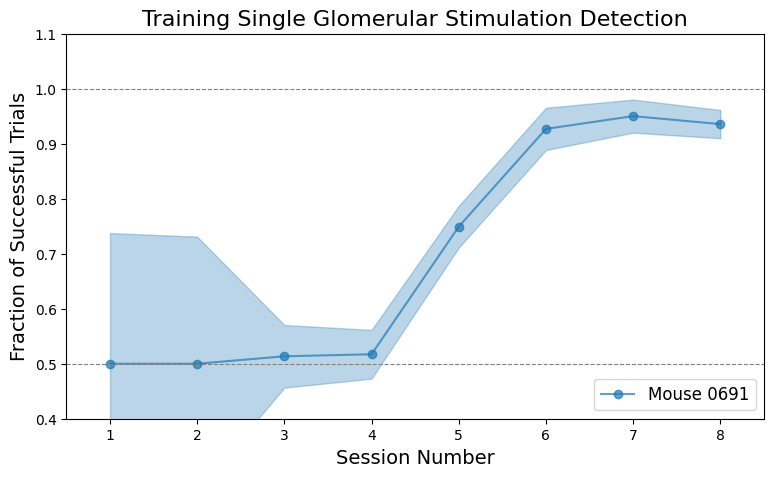

In [20]:
# Create a single figure with one subplot
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

# Get the maximum length of the sublists in avg_SUCCESS_plot to set x-axis limits
max_x_length = max(len(sublist) for sublist in avg_SUCCESS_plot)

# Loop through avg_SUCCESS_plot and plot each list for each mouse
for i, sublist in enumerate(avg_SUCCESS_plot):
    x = np.arange(len(sublist)) + 1  # x-axis values (session numbers)
    
    # Plot the data points and capture the color of the line
    line, = ax.plot(x, sublist, 'o-', label=f'Mouse {mouse[i]}', alpha=0.7)
    line_color = line.get_color()  # Get the color of the current line

    # Extract the confidence intervals for the current session
    confidence_interval_array = confidence_intervals[i]
    
    # Separate the upper and lower bounds from confidence_interval_array
    lower_bounds = [ci[1] for ci in confidence_interval_array]
    upper_bounds = [ci[0] for ci in confidence_interval_array]

    # Plot the shaded error region for the confidence interval
    ax.fill_between(x, lower_bounds, upper_bounds, color=line_color, alpha=0.3)

# Add dashed lines at y = 0.0, 0.5, and 1.0 for reference
ax.axhline(y=0.0, color='gray', linestyle='--', linewidth=0.8)
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.8)

# Set labels, title, and axis limits
ax.set_title(f'Training Single Glomerular Stimulation Detection', fontsize=16)
ax.set_ylabel('Fraction of Successful Trials', fontsize=14)
ax.set_xlabel('Session Number', fontsize=14)
ax.set_ylim(0.4, 1.1)  # Adjust y-axis limits for clarity
ax.set_xlim(0.5, max_x_length + 0.5)  # Set x-axis limits
ax.set_xticks(np.arange(1, max_x_length + 1))  # Ensure x-ticks match session numbers
ax.legend(loc='lower right', fontsize='large')  # Add a legend for the mice

# Display the plot
plt.show()

*In the Python file provided, all of the mice will be plotted together. In Jupyter notebook you only see the first mouse listed in **string_patterns** being plotted because foreloops over multiple cells do not run properly.

### Save the produced plots

This code with save the produced plot to a created folder in the **home_directory** which you specified at the beginning of the code. Specifically it will create a new folder in your home directory called _plots_behavior_.

In [21]:
# Save the figure as a .png file in the specified directory
save_directory = os.path.join(home_directory, 'plots_behavior')
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Define the full path for the plot
save_path = os.path.join(save_directory, f'SGS_Training_combinedmice.png')

# Save the plot
fig.savefig(save_path, dpi=300)

## THE END